# Topic Extraction mit der Latent Dirichlet Allocation (LDA)

### Motivation

* Welche Themen werden im Korpus behandelt?
* Diese Themen können durch statistische Sprachmodelle berechnet werden.
* Die Laten Dirichlet Allocation (LDA) ist ein häufig genutzer Algorithmus für diesen Zweck.


* Wie auch zuvor beim Clustering, wollen wir hier nicht die mathematische Implementierung des Algorithmus verstehen, sondern die dadurch entstehenden Möglichkeiten untersuchen.
* Sie sollen in diesem Notebook vor allem Eindruck bekommen, was möglich ist.

### Was ist ein "Thema/Topic"?

* Bei einem Thema denkt man als Mensch an einen abstrakten Begriff wie etwa Politik oder Musik.
* Statistische Algothmen wie diese verstehen jedoch keine Semantik und können daher keine abstrakten Beschreibungen liefern.

* Themen bestehen daher aus einer definierten Anzahl Wörtern z.B.:
```
Topic 1
 ---------
nato
schweden
finnland
türkei
beantragen
```
* Für jedes Dokument kann nun ein Score für jedes Thema berechnet werden.
* Der Score drückt aus wie gut ein Thema zum Dokument passt.
* Dokumente können so mit Themen beschrieben werden. 

## Einordnung in die Pipeline

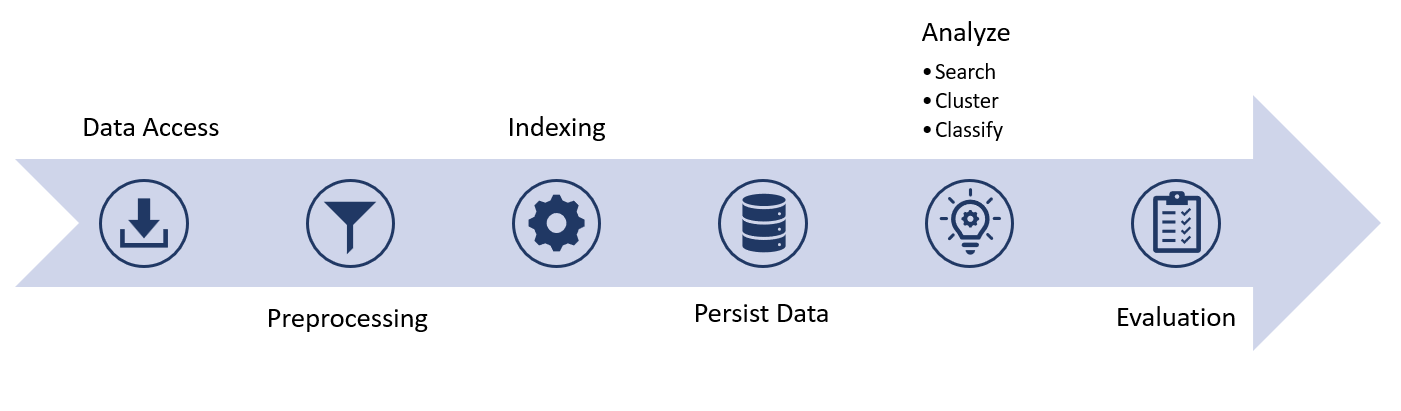

## Inhalt

1. Latent Dirichlet Allocation
2. Zuordnung der Dokumente zu Themen

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from tqdm.notebook import tqdm

from scipy.spatial.distance import cosine
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Vorverarbeitung

* In diesem Notebook nutzen wir nur die generellen RSS-Feeds (keine technischen).
* Die Schritte 1-3 werden wie gewohnt durchgeführt.

#### Data Acess & Preprocessing - Schritt 1 & 2

In [2]:
stopwords_german = set(stopwords.words("german"))
tokenizer = RegexpTokenizer("\w+")

def tok(text):
    tokens = tokenizer.tokenize(text)
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords_german]
    return tokens

In [174]:
DATA = "../../data/news/rss-nontech.txt"
with open(DATA, "r", encoding="utf8") as f:
    data = f.read()
    data = data.split("\n")
data = list(set(data))
# filter empty documents
data = [d for d in data if len(d) > 0]
len(data)

281

#### Indexing - Schritt 3

In [175]:
vectorizer = TfidfVectorizer(tokenizer=tok)
X = vectorizer.fit_transform(data)

# 2. Latent Dirichlet Allocation

* Der LDA-Algorithmus betrachtet den Korpus als eine Verteilung von Tokens pro Dokument.
* Zugrunde liegt die Annahme einer Dirichlet-Verteilung der Tokens.
* Jedes Dokument besitzt verborgene (latent) Topics, die durch den Algorithmus beschrieben werden.
* Topics werden aus häufig zusammen in Dokumenten vorkommenden Wörtern gebildet. 
* Aus Sicht des Algorithmus wird also die Wahrscheinlichkeit maximiert, das Wörter aus einem Topics häufig gemeinsam vorkommen.
* Eine umfassendere Erklärung des Algorithmus ist [hier](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) zu finden.

* Der Algorithmus ist, wie auch Clustering, im unüberwachten Lernen einzuordnen.
* LDA kann auch als Dimensionsreduktionsverfahren bezeichnet werden, denn:
  * Der Vektor eines Dokuments wird auf die verbliebenen Tokens reduziert, die das Topic repräsentieren.
  * Dies geschiet unter Anwendung minimalem Informationsverlustes.

#### Wichtig

* Die LDA ist ein probabilistisches Modell. Es werden Samples aus der Dirichlet Verteilung gezogen und hinsihchtlich der Maximum Likelihood Estimation (MLE) optimiert.
* Dadurch erziehlt das Verfahren, wie auch K-means, bei mehreren Durchläufen auf den gleichen Daten _unterschiedliche_ Ergebnisse!
* Zwar sollten sich die Ergebnisse stark ähneln, aber die Nummering der Topics wird auf jeden Fall verschieden sein!

* Es wird die [LDA-Implmentierung](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) von Scikit-learn verwendet.
* Wir müssen den Parameter ``n_components`` einstellen.
* Der Parameter legt die Anzahl an Topics fest, die gesucht werden.
* Auch hier: eine gute Auswahl der Anzahl Topics ist schwer. Dies sollte iterativ ausprobiert und angepasst werden!
* Denn:
  * Zu wenige Topics: Die Topics sind vermischt und ungenau (underfitting).
  * Zu viele Topics: Die Topics sind zu spezifisch und generalisieren nicht (overfitting).

In [210]:
# configure LDA
lda = LatentDirichletAllocation(n_components=20, random_state=0)
# train
lda.fit(X)

LatentDirichletAllocation(n_components=20, random_state=0)

Ausgabe eines LDA-Topics:

* Topics sind im Attribut ``components_``.
* Dieses enthält eine Matrix (numpy array) mit einer Gewichtung jedes Tokens für jedes Topic.
* Mit ``argsort`` erhalten wir die Indices der am stärksten gewichteten Tokens für ein Topic.
* Zu jedem Topic lassen wir uns die 6 bestens Tokens anzeigen.

In [211]:
# die besten 6 Tokens für Topic 0, das sind die letzten 6 im Topic-Vektor.
topic_0 = lda.components_[0].argsort()[-6:]
topic_0

array([ 313,  355, 2912, 1001, 2532, 2048], dtype=int64)

In [212]:
topic_0

array([ 313,  355, 2912, 1001, 2532, 2048], dtype=int64)

In [213]:
vocabulary = vectorizer.get_feature_names_out()

In [214]:
# Zugriff auf die besten Tokens über das Vokabular.
vocabulary[topic_0]

array(['beantragen', 'beitritt', 'türkei', 'finnland', 'schweden', 'nato'],
      dtype=object)

In [215]:
# Die Gewichtung für die Tokens
lda.components_[0][topic_0]

array([0.97778448, 1.15022571, 1.75406386, 2.58027412, 2.633236  ,
       3.07297334])

In [216]:
# zusammengefasst
def get_topic(idx, model, n=6):
    topic = model.components_[idx]
    top_features_ind = topic.argsort()[: -n - 1 : -1]
    return [vocabulary[i] for i in top_features_ind]

In [217]:
get_topic(5, lda)

['gasembargo', 'eu', 'feld', 'lars', 'schlägt', 'kracht']

In [218]:
def plot_top_words(model, n_top_words):
    rows = model.components_
    plot_columns = model.components_
    fig, axes = plt.subplots(4, 5, figsize=(30, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [vocabulary[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Topic modeling LDA of RSS-News", fontsize=40)

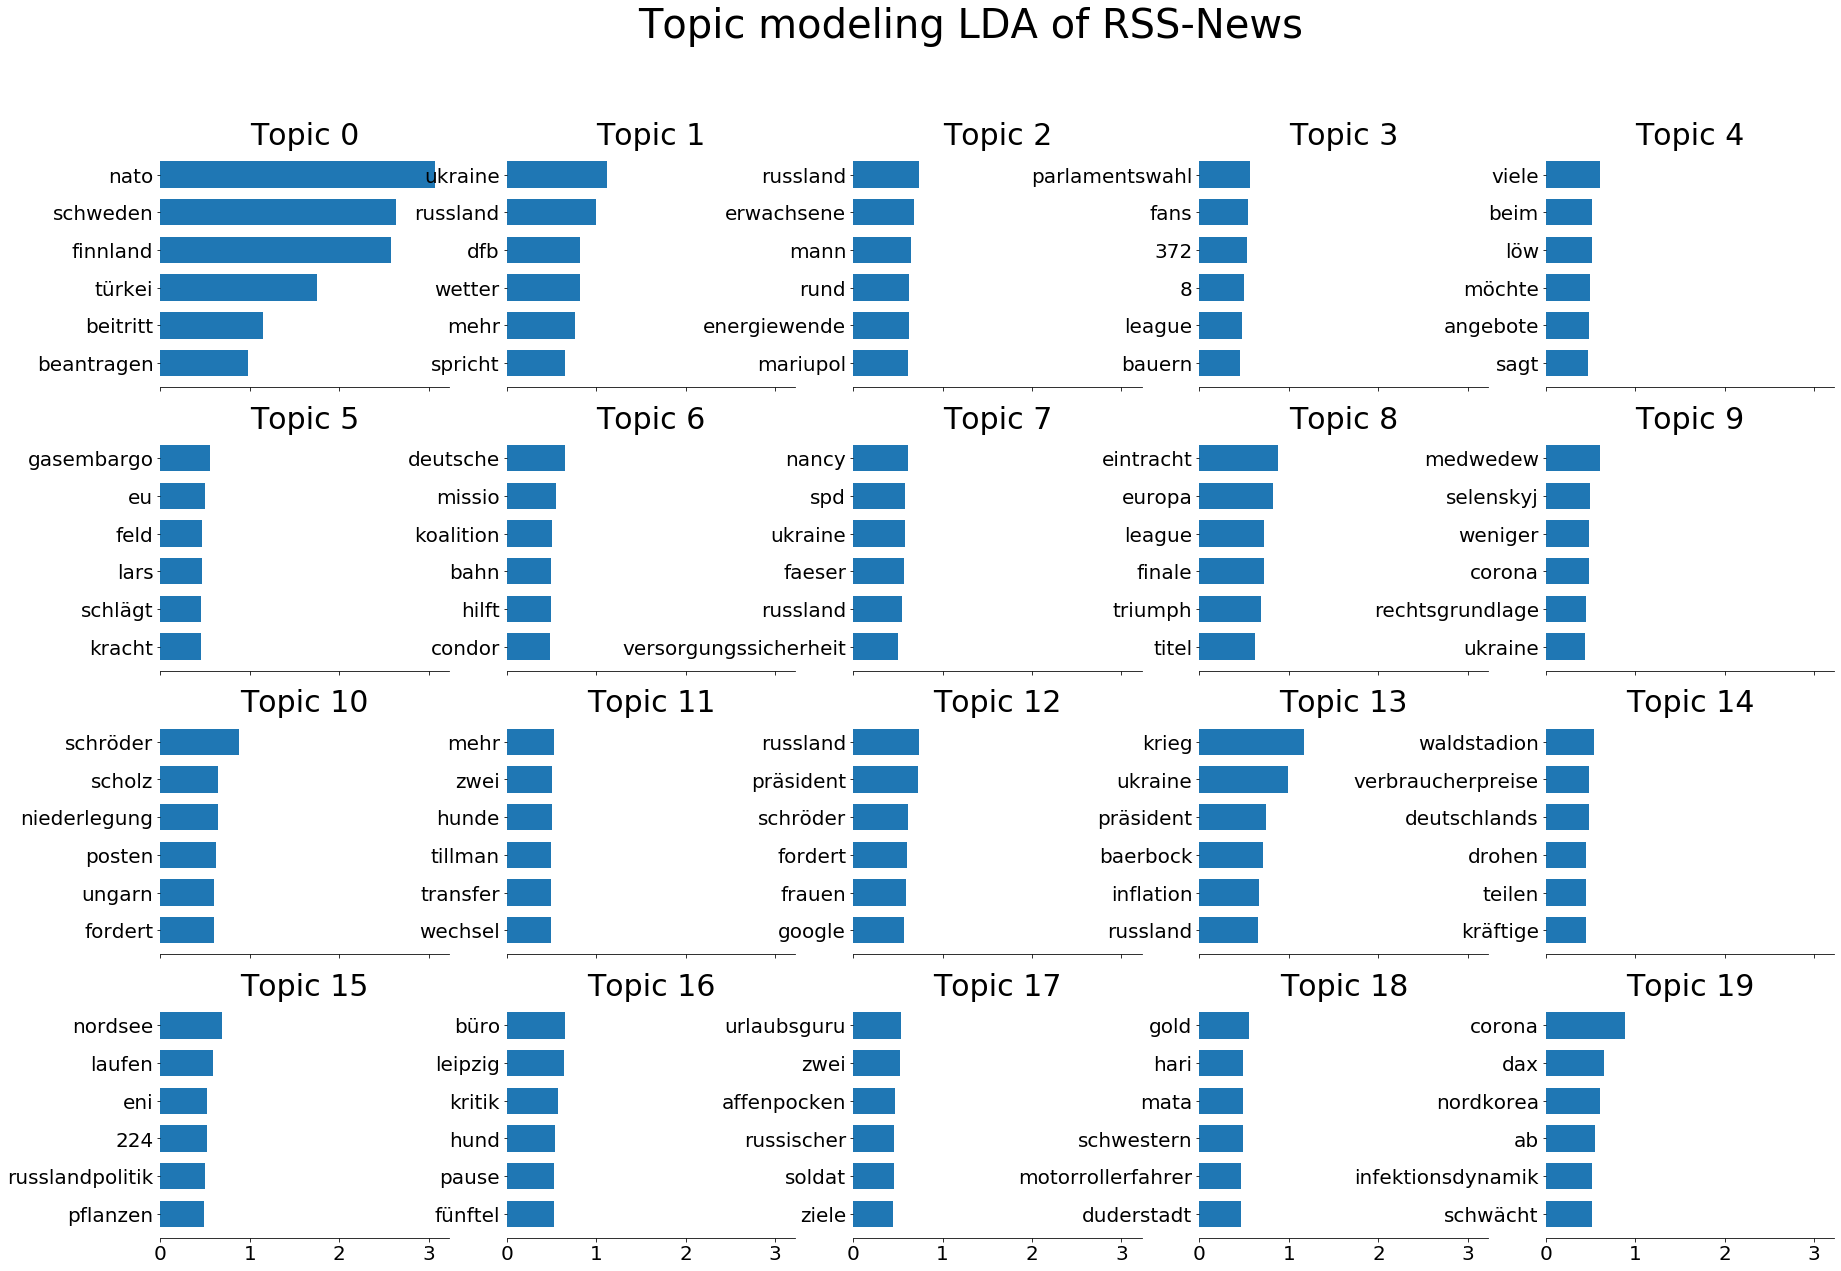

In [219]:
plot_top_words(lda, 6)

## Evaluation

* Es sind einige sehr treffende Topics entstanden:
  * z.B. Topic 0, 6, 7, 10, 12 etc...
* Jedoch sind auch viele durchmischte Topics ohne wirklich übergeordnetes Thema zu finden.
  * z.B. Topic 1, 2
  * Dazu muss jedoch gesagt werden: bisher haben wir nicht in die Daten geschaut.
* Betrachtet man die LDA Gewichtungen so fällt auf:
  * Topic 0 ist sehr stark gewichtet.
* Ist die Anzahl Topics richtig gewählt worden?

* Bei der vorliegenden Domäne handelt es sich um kurze Dokumente aus dem Bereich allgemeine Nachrichten.
* Dies führt zu einer sehr großen Anzahl deutlich verschiedener Themen.
* Ebenfalls kann die kurze Dokumentlänge dazu beitragen, dass vor allem kleinere Themen nicht erfasst werden und in der Masse untergehen.

## 3. Bestimmung eines Themas zu einem Dokument

In [229]:
def get_doc_topic(n):
    # Berechnung eines Topics für ein Dokument mit transform.
    topic = lda.transform(X[n])
    # Sortieren nach dem besten Score 
    topic_idx = topic.argsort()[:,-1:][0][0]
    # Abspeichern der Gewichtung
    topic_weight = topic[:,topic_idx][0]
    print(f"Dokument {n} hat das Topic {topic_idx} mit einem Gewicht von {topic_weight}.")
    print("Dokument:", data[n])
    print(f"Topic {topic_idx}:", get_topic(topic_idx, lda))

In [230]:
get_doc_topic(2)

Dokument 2 hat das Topic 18 mit einem Gewicht von 0.7244912966085878.
Dokument: Göttingen: Motorrollerfahrer stirbt bei Unfall nahe Duderstadt
Topic 18: ['gold', 'hari', 'mata', 'schwestern', 'motorrollerfahrer', 'duderstadt']


In [228]:
def get_best_weighted(model):
    weights = pd.DataFrame(columns=["document", "topic", "weight"])
    for idx, doc in enumerate(data):
        topic = model.transform(X[idx])
        topic_idx = topic.argsort()[:, -1:][0][0]
        topic_weight = topic[:, topic_idx][0]
        weights = weights.append({"document": idx, "topic": topic_idx, "weight": topic_weight}, ignore_index=True)
    return weights.sort_values("weight", ascending=False)

In [227]:
# übersicht der am "besten" gewichteten Dokumente nach dem besten Topic
get_best_weighted(lda)

,document,topic,weight
73,73.0,14.0,0.858345
11,11.0,18.0,0.854751
227,227.0,2.0,0.854448
255,255.0,0.0,0.854073
136,136.0,15.0,0.853936
...,...,...,...
63,63.0,7.0,0.520160
47,47.0,19.0,0.498411
127,127.0,0.0,0.456484
41,41.0,0.0,0.427275


In [238]:
# leider nicht wirklich treffend...
get_doc_topic(73)

Dokument 73 hat das Topic 14 mit einem Gewicht von 0.8583448032069723.
Dokument: Berlin hacken ist wie Pompeji bombardieren Nach der NRW-Wahl bejubelt der Sieger das bislang völlig unbekannte „Team Wüst“. Die AfD bekämpft sich selbst - und russische Hacker greifen das sowieso kaum nutzbare Landesportal Berlins an. Darum geht es im „Kick-off Politik - Wochenrückblick“ mit WELT-Chefkorrespondent Sascha Lehnartz.
Topic 14: ['waldstadion', 'verbraucherpreise', 'deutschlands', 'drohen', 'teilen', 'kräftige']


In [240]:
# auch Platz 2 leider überhaupt nicht treffend...
get_doc_topic(11)

Dokument 11 hat das Topic 18 mit einem Gewicht von 0.8547512290967269.
Dokument: „Man hört von Forderungen der Todesstrafe für gefangene Asow-Kämpfer“ Verletzte ukrainische Kämpfer, deren Schicksal in Putins Hand liegt, seien Bilder, die dem russischen Präsidenten derzeit sehr helfen, sagt WELT-Reporter Paul Sonntag. Weitere Soldaten seien aus dem Asow-Stahlwerk evakuiert worden, Russland spreche jedoch von Aufgabe.
Topic 18: ['gold', 'hari', 'mata', 'schwestern', 'motorrollerfahrer', 'duderstadt']


In [241]:
# immerhin etwas besser...
get_doc_topic(227)

Dokument 227 hat das Topic 2 mit einem Gewicht von 0.8544479911031366.
Dokument: „Die Materialschlacht geht weiter – sie wird Wochen, vielleicht Monate dauern“ „Trotz materieller Übermacht haben die Russen bisher keine überzeugenden taktischen Leistungen geboten“, analysiert Oberst a. D. Wolfgang Richter die militärische Lage im Ukraine-Krieg. Im WELT-Interview betont er: „Es sieht so aus, als ob die Russen etwas die Oberhand bekommen könnten.“
Topic 2: ['russland', 'erwachsene', 'mann', 'rund', 'energiewende', 'mariupol']


## Evaluation

* Die Zuordnung der Dokumente zu Themen ist schlecht.
* Es sollte daher eine bessere Vorverarbeitung in Betracht gezogen werden.
* Zudem stellt sich die Frage, ob das Verfahren als Anwednung für die Bestimmung von Themen für diesen Korpus geeignet ist.
* Viel mehr jedoch lohnt sich das Verfahren als Gewinnung einer Übersicht für die Frage: **Um was geht es in den Dokumenten im Korpus?**

## WeitereMöglichkeiten

* Eine ähnliche Möglichkeit für Topic Modeling ist die Negative Matrix Factorization (NNM).
* BERT-Bidirectional Encoder Representations with Transformers
  * DeepLearning
  * Kann Semantik und kontextuelle Zusammenhänge besser modellieren
  * Für die Anwendung ist das Verständnis von WordEmbeddings und Transformer-Netzen nötig.
